# **Requirements**


In [97]:
# !pip install seaborn
# !pip install pandas

# !pip install numpy
# !pip install matplotlib

# !pip install openpyxl

# !pip install pydmd

In [98]:
import warnings
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from scipy import linalg

from numpy import matrix as m

from scipy.linalg import norm
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.linalg import svd, eig, pinv
np.random.seed(42)

rcParams['figure.figsize'] = 11, 4

warnings.filterwarnings('ignore')

In [99]:
settings = {
    "random_state": 42,
    "SSA": {
        "L": None,
        "F": 180,
    },
    "Clustering": {
        "distance_metric": "frobenius",
    }
}

# **Dataset Preparation**


In [100]:

data = pd.ExcelFile("data/hpe-kota-bandung.xlsx")
sheet_name = 'Jawa Barat - Kota Bandung'
df = data.parse(sheet_name)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Columns: 1459 entries,  Komoditas (Rp)  to 28/12/2024
dtypes: object(1459)
memory usage: 239.5+ KB


# **Preprocessing**


In [101]:
class Preprocessing:
    def __init__(self):
        pass

    def remove_nan(self, df):
        df = df.replace('-', np.nan)
        df = df.loc[:, df.isnull().mean() < .3]
        df = df.dropna(how='all')
        df = df.dropna(axis=1, how='all')
        return df

    def adjust_datatype(self, df):
        return df.astype(float) * 1000

    def fit_transform(self, df):
        df.columns = df.columns.str.strip()
        df = df.set_index('Komoditas (Rp)').transpose()
        df = self.remove_nan(df)
        df = self.adjust_datatype(df)
        df.index.names = ['Date']
        df.index = pd.to_datetime(df.index, format='%d/%m/%Y')
        df = df.sort_index().asfreq('D')
        return df

In [102]:
processor = Preprocessing()
df = processor.fit_transform(df)

# **EDA**


In [103]:


def test_stationarity_to_df(timeseries):
    df_test = adfuller(timeseries, autolag='AIC')
    results = {
        'Test Statistic': f"{df_test[0]:.3f}",
        'p-value': f"{df_test[1]:.3f}",
        'Critical Value (1%)': f"{df_test[4]['1%']:.3f}",
        'Critical Value (5%)': f"{df_test[4]['5%']:.3f}",
        'Critical Value (10%)': f"{df_test[4]['10%']:.3f}",
        'Stationary': 'Y' if df_test[1] <= 0.05 else 'N'
    }
    return results

def plot_acf_pacf(ts, lags=40):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(ts, lags=lags, ax=ax[0])
    plot_pacf(ts, lags=lags, ax=ax[1])
    plt.show()

results_list = []

for column in df.columns:
    ts = df[column].dropna()
    try:
        result = test_stationarity_to_df(ts)
    except Exception as e:
        continue
    result['Column'] = column
    results_list.append(result)

# Convert the results list to a Pandas DataFrame
results_df = pd.DataFrame(results_list)

results_df.set_index('Column', inplace=True)
results_df


,Test Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%),Stationary
Column,,,,,,
Beras Premium,-0.936,0.776,-3.435,-2.864,-2.568,N
Beras Medium,-1.307,0.626,-3.435,-2.864,-2.568,N
Kedelai Biji Kering (Impor),-2.166,0.219,-3.436,-2.864,-2.568,N
Bawang Merah,-3.515,0.008,-3.435,-2.864,-2.568,Y
Bawang Putih Bonggol,-1.111,0.711,-3.435,-2.864,-2.568,N
Cabai Merah Keriting,-3.079,0.028,-3.435,-2.864,-2.568,Y
Cabai Rawit Merah,-4.823,0.000,-3.435,-2.864,-2.568,Y
Daging Sapi Murni,-1.625,0.470,-3.435,-2.864,-2.568,N
Daging Ayam Ras,-5.816,0.000,-3.435,-2.864,-2.568,Y


# **Modeling**


In [104]:
# ----------------- [Singular Spectrum Analysis] ----------------- #
# Credits: https://github.com/ganik/pySSA
class SSA(object):
    '''Singular Spectrum Analysis object'''
    def __init__(self, time_series):
        self.ts = pd.DataFrame(time_series)
        self.ts_name = self.ts.columns.tolist()[0]
        if self.ts_name == 0:
            self.ts_name = 'ts'
        self.ts_v = self.ts.values
        self.ts_N = self.ts.shape[0]
        self.freq = self.ts.index.inferred_freq

    @staticmethod
    def _printer(name, *args):
        '''Helper function to print messages neatly'''
        print('-'*40)
        print(name+':')
        for msg in args:
            print(msg)

    @staticmethod
    def _dot(x, y):
        '''Alternative formulation of dot product to allow missing values in arrays/matrices'''
        pass
    
    @classmethod
    def get_contributions(self, X=None, s=None, plot=True):
        '''Calculate the relative contribution of each of the singular values'''
        lambdas = np.power(s, 2)
        frob_norm = np.linalg.norm(X)
        ret = pd.DataFrame(lambdas/(frob_norm**2), columns=['Contribution'])
        ret['Contribution'] = ret.Contribution.round(4)
        if plot:
            ax = ret[ret.Contribution != 0].plot.bar(legend=False)
            ax.set_xlabel("Lambda_i")
            ax.set_title('Non-zero contributions of Lambda_i')
            vals = ax.get_yticks()
            ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
            return ax
        return ret[ret.Contribution > 0]

    @staticmethod
    def diagonal_averaging(hankel_matrix):
        '''Performs anti-diagonal averaging from given hankel matrix
        Returns: Pandas DataFrame object containing the reconstructed series'''
        mat = m(hankel_matrix)
        L, K = mat.shape
        L_star, K_star = min(L, K), max(L, K)
        new = np.zeros((L, K))
        if L > K:
            mat = mat.T
        ret = []

        for k in range(1-K_star, L_star):
            mask = np.eye(K_star, k=k, dtype='bool')[::-1][:L_star, :]
            mask_n = sum(sum(mask))
            ma = np.ma.masked_array(mat.A, mask=1-mask)
            ret += [ma.sum()/mask_n]

        return pd.DataFrame(ret).rename(columns={0: 'Reconstruction'})

    def view_time_series(self):
        '''Plot the time series'''
        self.ts.plot(title='Original Time Series')

    def embed(self, embedding_dimension=None, suspected_frequency=None, verbose=False, return_df=False):
        '''Embed the time series with embedding_dimension window size.
        Optional: suspected_frequency changes embedding_dimension such that it is divisible by suspected frequency'''
        if not embedding_dimension:
            self.embedding_dimension = self.ts_N//2
        else:
            self.embedding_dimension = embedding_dimension
        if suspected_frequency:
            self.suspected_frequency = suspected_frequency
            self.embedding_dimension = (
                self.embedding_dimension//self.suspected_frequency)*self.suspected_frequency

        self.K = self.ts_N-self.embedding_dimension+1
        self.X = m(linalg.hankel(self.ts, np.zeros(
            self.embedding_dimension))).T[:, :self.K]
        self.X_df = pd.DataFrame(self.X)
        self.X_complete = self.X_df.dropna(axis=1)
        self.X_com = m(self.X_complete.values)
        self.X_missing = self.X_df.drop(self.X_complete.columns, axis=1)
        self.X_miss = m(self.X_missing.values)
        self.trajectory_dimentions = self.X_df.shape
        self.complete_dimensions = self.X_complete.shape
        self.missing_dimensions = self.X_missing.shape
        self.no_missing = self.missing_dimensions[1] == 0

        if verbose:
            msg1 = 'Embedding dimension\t:  {}\nTrajectory dimensions\t: {}'
            msg2 = 'Complete dimension\t: {}\nMissing dimension     \t: {}'
            msg1 = msg1.format(self.embedding_dimension,
                               self.trajectory_dimentions)
            msg2 = msg2.format(self.complete_dimensions,
                               self.missing_dimensions)
            self._printer('EMBEDDING SUMMARY', msg1, msg2)

        if return_df:
            return self.X_df

    def decompose(self, verbose=False):
        '''Perform the Singular Value Decomposition and identify the rank of the embedding subspace
        Characteristic of projection: the proportion of variance captured in the subspace'''
        X = self.X_com
        self.S = X*X.T
        self.U, self.s, self.V = linalg.svd(self.S)
        self.U, self.s, self.V = m(self.U), np.sqrt(self.s), m(self.V)
        self.d = np.linalg.matrix_rank(X)
        Vs, Xs, Ys, Zs = {}, {}, {}, {}
        for i in range(self.d):
            Zs[i] = self.s[i]*self.V[:, i]
            Vs[i] = X.T*(self.U[:, i]/self.s[i])
            Ys[i] = self.s[i]*self.U[:, i]
            Xs[i] = Ys[i]*(m(Vs[i]).T)
        self.Vs, self.Xs = Vs, Xs
        self.s_contributions = self.get_contributions(X, self.s, False)
        self.r = len(self.s_contributions[self.s_contributions > 0])
        self.r_characteristic = round(
            (self.s[:self.r]**2).sum()/(self.s**2).sum(), 4)
        self.orthonormal_base = {i: self.U[:, i] for i in range(self.r)}

        if verbose:
            msg1 = 'Rank of trajectory\t\t: {}\nDimension of projection space\t: {}'
            msg1 = msg1.format(self.d, self.r)
            msg2 = 'Characteristic of projection\t: {}'.format(
                self.r_characteristic)
            self._printer('DECOMPOSITION SUMMARY', msg1, msg2)

    def view_s_contributions(self, adjust_scale=False, cumulative=False):
        '''View the contribution to variance of each singular value and its corresponding signal'''
        contribs = self.s_contributions.copy()
        contribs = contribs[contribs.Contribution != 0]
        
        if cumulative:
            contribs['Contribution'] = contribs.Contribution.cumsum()
        if adjust_scale:
            contribs = (1/contribs).max()*1.1 - (1/contribs)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        contribs.plot.bar(ax=ax, color='skyblue', legend=False)
        
        ax.set_xlabel("Singular Values (Singular_i)", fontsize=12)
        ax.set_ylabel("Contribution to Variance (%)", fontsize=12)
        ax.set_title('Contribution of Singular Values to Variance' +
                    (' (Cumulative)' if cumulative else '') +
                    (' (Scaled)' if adjust_scale else ''), fontsize=14)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.tick_params(axis='x', labelrotation=45, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in vals])
        for bar in ax.patches:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{height:.2%}', xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 5), textcoords="offset points", ha='center', fontsize=10)
        plt.tight_layout()
        plt.show()        
        return contribs

    @classmethod
    def view_reconstruction(cls, *hankel, names=None, return_df=False, plot=True, symmetric_plots=False):
        '''Visualise the reconstruction of the hankel matrix/matrices passed to *hankel'''
        hankel_mat = None
        for han in hankel:
            if isinstance(hankel_mat, m):
                hankel_mat = hankel_mat + han
            else:
                hankel_mat = han.copy()
        hankel_full = cls.diagonal_averaging(hankel_mat)
        title = 'Reconstruction of signal'
        if names or names == 0:
            title += ' associated with singular value{}: {}'
            title = title.format('' if len(str(names)) == 1 else 's', names)
        if plot:
            ax = hankel_full.plot(legend=False, title=title)
            if symmetric_plots:
                velocity = hankel_full.abs().max()[0]
                ax.set_ylim(bottom=-velocity, top=velocity)
        if return_df:
            return hankel_full

    def _forecast_prep(self, singular_values=None):
        self.X_com_hat = np.zeros(self.complete_dimensions)
        self.verticality_coefficient = 0
        self.forecast_orthonormal_base = {}
        if singular_values:
            try:
                for i in singular_values:
                    self.forecast_orthonormal_base[i] = self.orthonormal_base[i]
            except:
                if singular_values == 0:
                    self.forecast_orthonormal_base[0] = self.orthonormal_base[0]
                else:
                    raise (
                        'Please pass in a list/array of singular value indices to use for forecast')
        else:
            self.forecast_orthonormal_base = self.orthonormal_base
        self.R = np.zeros(self.forecast_orthonormal_base[0].shape)[:-1]
        for Pi in self.forecast_orthonormal_base.values():
            self.X_com_hat += Pi*Pi.T*self.X_com
            pi = np.ravel(Pi)[-1]
            self.verticality_coefficient += pi**2
            self.R += pi*Pi[:-1]
        self.R = m(self.R/(1-self.verticality_coefficient))
        self.X_com_tilde = self.diagonal_averaging(self.X_com_hat)

    def forecast_recurrent(self, steps_ahead=12, singular_values=None, plot=False, return_df=False, **plotargs):
        '''Forecast from last point of original time series up to steps_ahead using recurrent methodology
        This method also fills any missing data from the original time series.'''
        try:
            self.X_com_hat
        except (AttributeError):
            self._forecast_prep(singular_values)
        self.ts_forecast = np.array(self.ts_v[0])
        for i in range(1, self.ts_N+steps_ahead):
            try:
                if np.isnan(self.ts_v[i]):
                    x = self.R.T * \
                        m(self.ts_forecast[max(0, i-self.R.shape[0]): i]).T
                    self.ts_forecast = np.append(self.ts_forecast, x[0])
                else:
                    self.ts_forecast = np.append(
                        self.ts_forecast, self.ts_v[i])
            except IndexError:
                x = self.R.T*m(self.ts_forecast[i-self.R.shape[0]: i]).T
                self.ts_forecast = np.append(self.ts_forecast, x[0])
        self.forecast_N = i+1
        new_index = pd.date_range(
            start=self.ts.index.min(), periods=self.forecast_N, freq=self.freq)
        forecast_df = pd.DataFrame(self.ts_forecast, columns=[
                         'Forecast'], index=new_index)
        forecast_df['Original'] = np.append(self.ts_v, [np.nan]*steps_ahead)
        if plot:
            forecast_df.plot(
                title='Forecasted vs. original time series', **plotargs)
        if return_df:
            return forecast_df

In [105]:
# ----------------- [Metrics] ----------------- #
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / np.where(denominator == 0, np.finfo(float).eps, denominator))

# ----------------- [Beras Premium] ----------------- #
# ----------------- [Beras Medium] ----------------- #
# ----------------- [Kedelai Biji Kering (Impor)] ----------------- #
# ----------------- [Bawang Merah] ----------------- #
# ----------------- [Bawang Putih Bonggol] ----------------- #
# ----------------- [Cabai Merah Keriting] ----------------- #
# ----------------- [Cabai Rawit Merah] ----------------- #
# ----------------- [Daging Sapi Murni] ----------------- #
# ----------------- [Daging Ayam Ras] ----------------- #
# ----------------- [Telur Ayam Ras] ----------------- #
# ----------------- [Gula Konsumsi] ----------------- #
# ----------------- [Minyak Goreng Kemasan Sederhana] ----------------- #
# ----------------- [Tepung Terigu (Curah)] ----------------- #


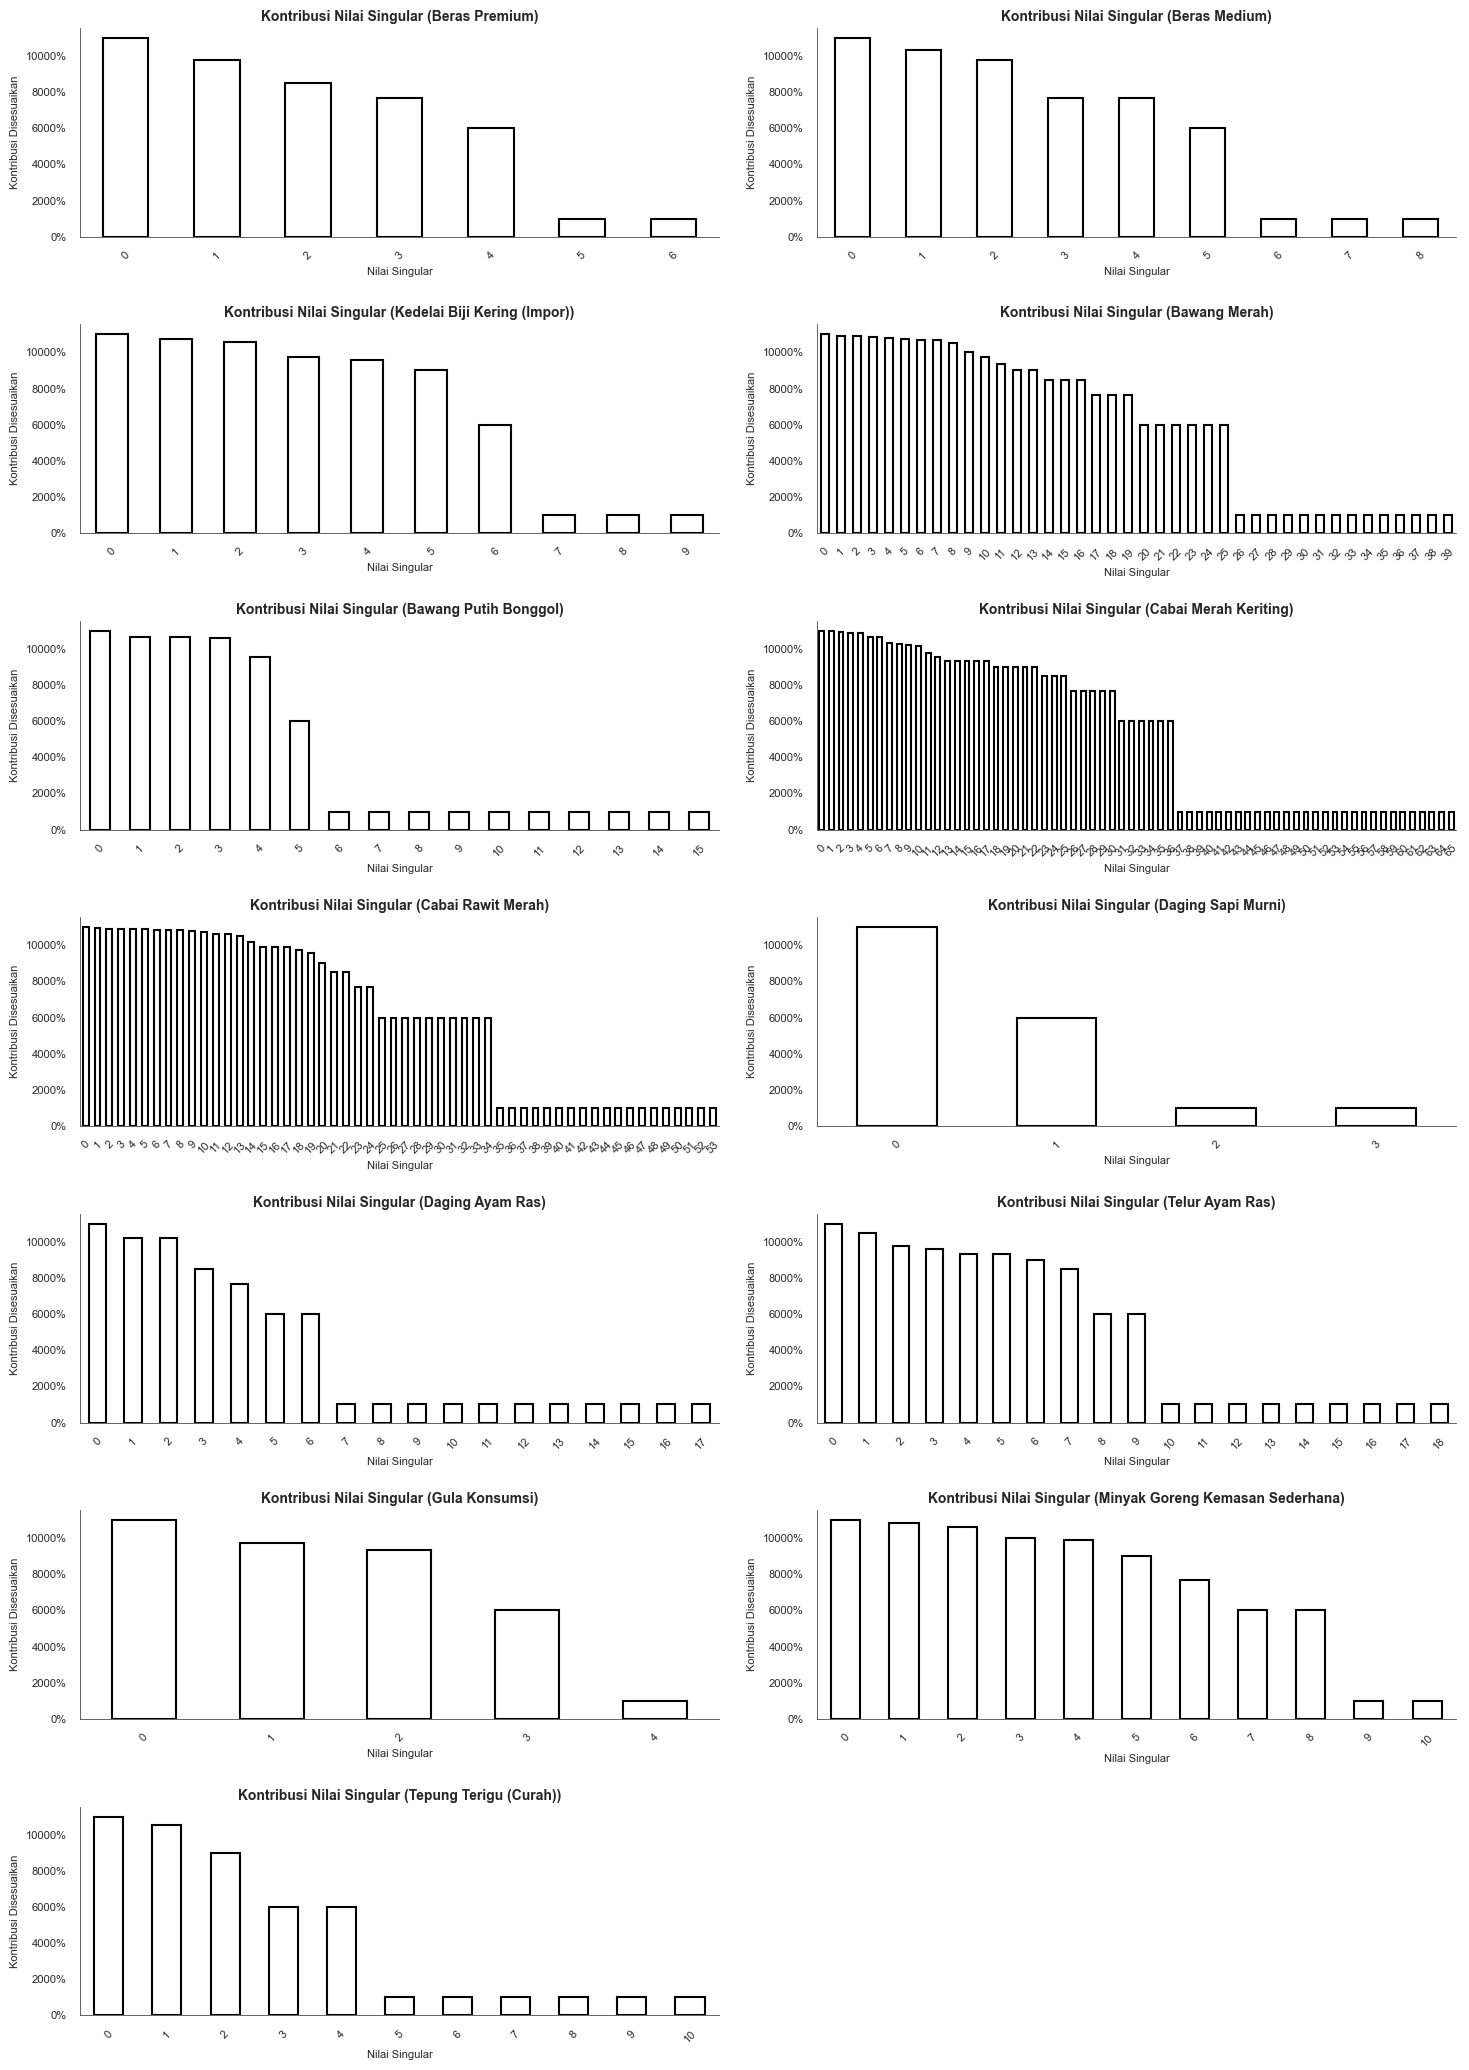

In [106]:
sns.set(style="white")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#E5E5E5'
plt.rcParams['grid.linestyle'] = '--'

n_cols = 2
n_rows = (len(df.columns) + 1) // n_cols
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
ax = ax.flatten()

for i, col in enumerate(df.columns):
    print(f"# ----------------- [{col}] ----------------- #")
    
    ts = df[[col]].copy()
    ts = ts.interpolate(method='time')
    
    model = SSA(ts)
    model.embed(embedding_dimension=None, suspected_frequency=180, verbose=False)
    model.decompose(False)
    
    contribution = model.get_contributions(model.X_com, model.s, False)
    
    contribution = (1/contribution).max()*1.1 - (1/contribution)
    
    curr_ax = ax[i]
    contribution['Contribution'].plot(
        kind='bar',
        ax=curr_ax,
        color='white',             # Hollow style with no fill
        edgecolor='black',         # Black borders for bars
        linewidth=1.5,             # Thickness of bar edges
        alpha=1.0,
    )
    
    curr_ax.set_title(f"Kontribusi Nilai Singular ({col})", fontsize=10, fontweight='bold', pad=5)
    curr_ax.set_xlabel("Nilai Singular", fontsize=8)
    curr_ax.set_ylabel("Kontribusi Disesuaikan", fontsize=8)
    
    # Minimalist grid and spines
    curr_ax.grid(False)  # Turn off grid
    curr_ax.spines['top'].set_visible(False)
    curr_ax.spines['right'].set_visible(False)
    curr_ax.spines['left'].set_linewidth(0.5)
    curr_ax.spines['bottom'].set_linewidth(0.5)
    
    # Adjust ticks and labels
    vals = curr_ax.get_yticks()
    curr_ax.set_yticklabels([f"{x:.0f}%" for x in vals], fontsize=8)
    curr_ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    curr_ax.tick_params(axis='y', labelsize=8)

# Turn off unused subplots
for i in range(len(df.columns), len(ax)):
    ax[i].axis('off')

plt.tight_layout(pad=1.5)
plt.show()


# ----------------- [Beras Premium] ----------------- #
MAPE: 15.75
SMAPE: 17.35
# ----------------- [Beras Medium] ----------------- #
MAPE: 14.85
SMAPE: 15.97
# ----------------- [Kedelai Biji Kering (Impor)] ----------------- #
MAPE: 15.73
SMAPE: 14.11
# ----------------- [Bawang Merah] ----------------- #
MAPE: 26.70
SMAPE: 28.38
# ----------------- [Bawang Putih Bonggol] ----------------- #
MAPE: 24.34
SMAPE: 29.28
# ----------------- [Cabai Merah Keriting] ----------------- #
MAPE: 36.02
SMAPE: 31.31
# ----------------- [Cabai Rawit Merah] ----------------- #
MAPE: 37.77
SMAPE: 32.11
# ----------------- [Daging Sapi Murni] ----------------- #
MAPE: 6.36
SMAPE: 6.70
# ----------------- [Daging Ayam Ras] ----------------- #
MAPE: 7.86
SMAPE: 7.99
# ----------------- [Telur Ayam Ras] ----------------- #
MAPE: 10.59
SMAPE: 11.29
# ----------------- [Gula Konsumsi] ----------------- #
MAPE: 16.23
SMAPE: 18.36
# ----------------- [Minyak Goreng Kemasan Sederhana] ----------------- #
MA

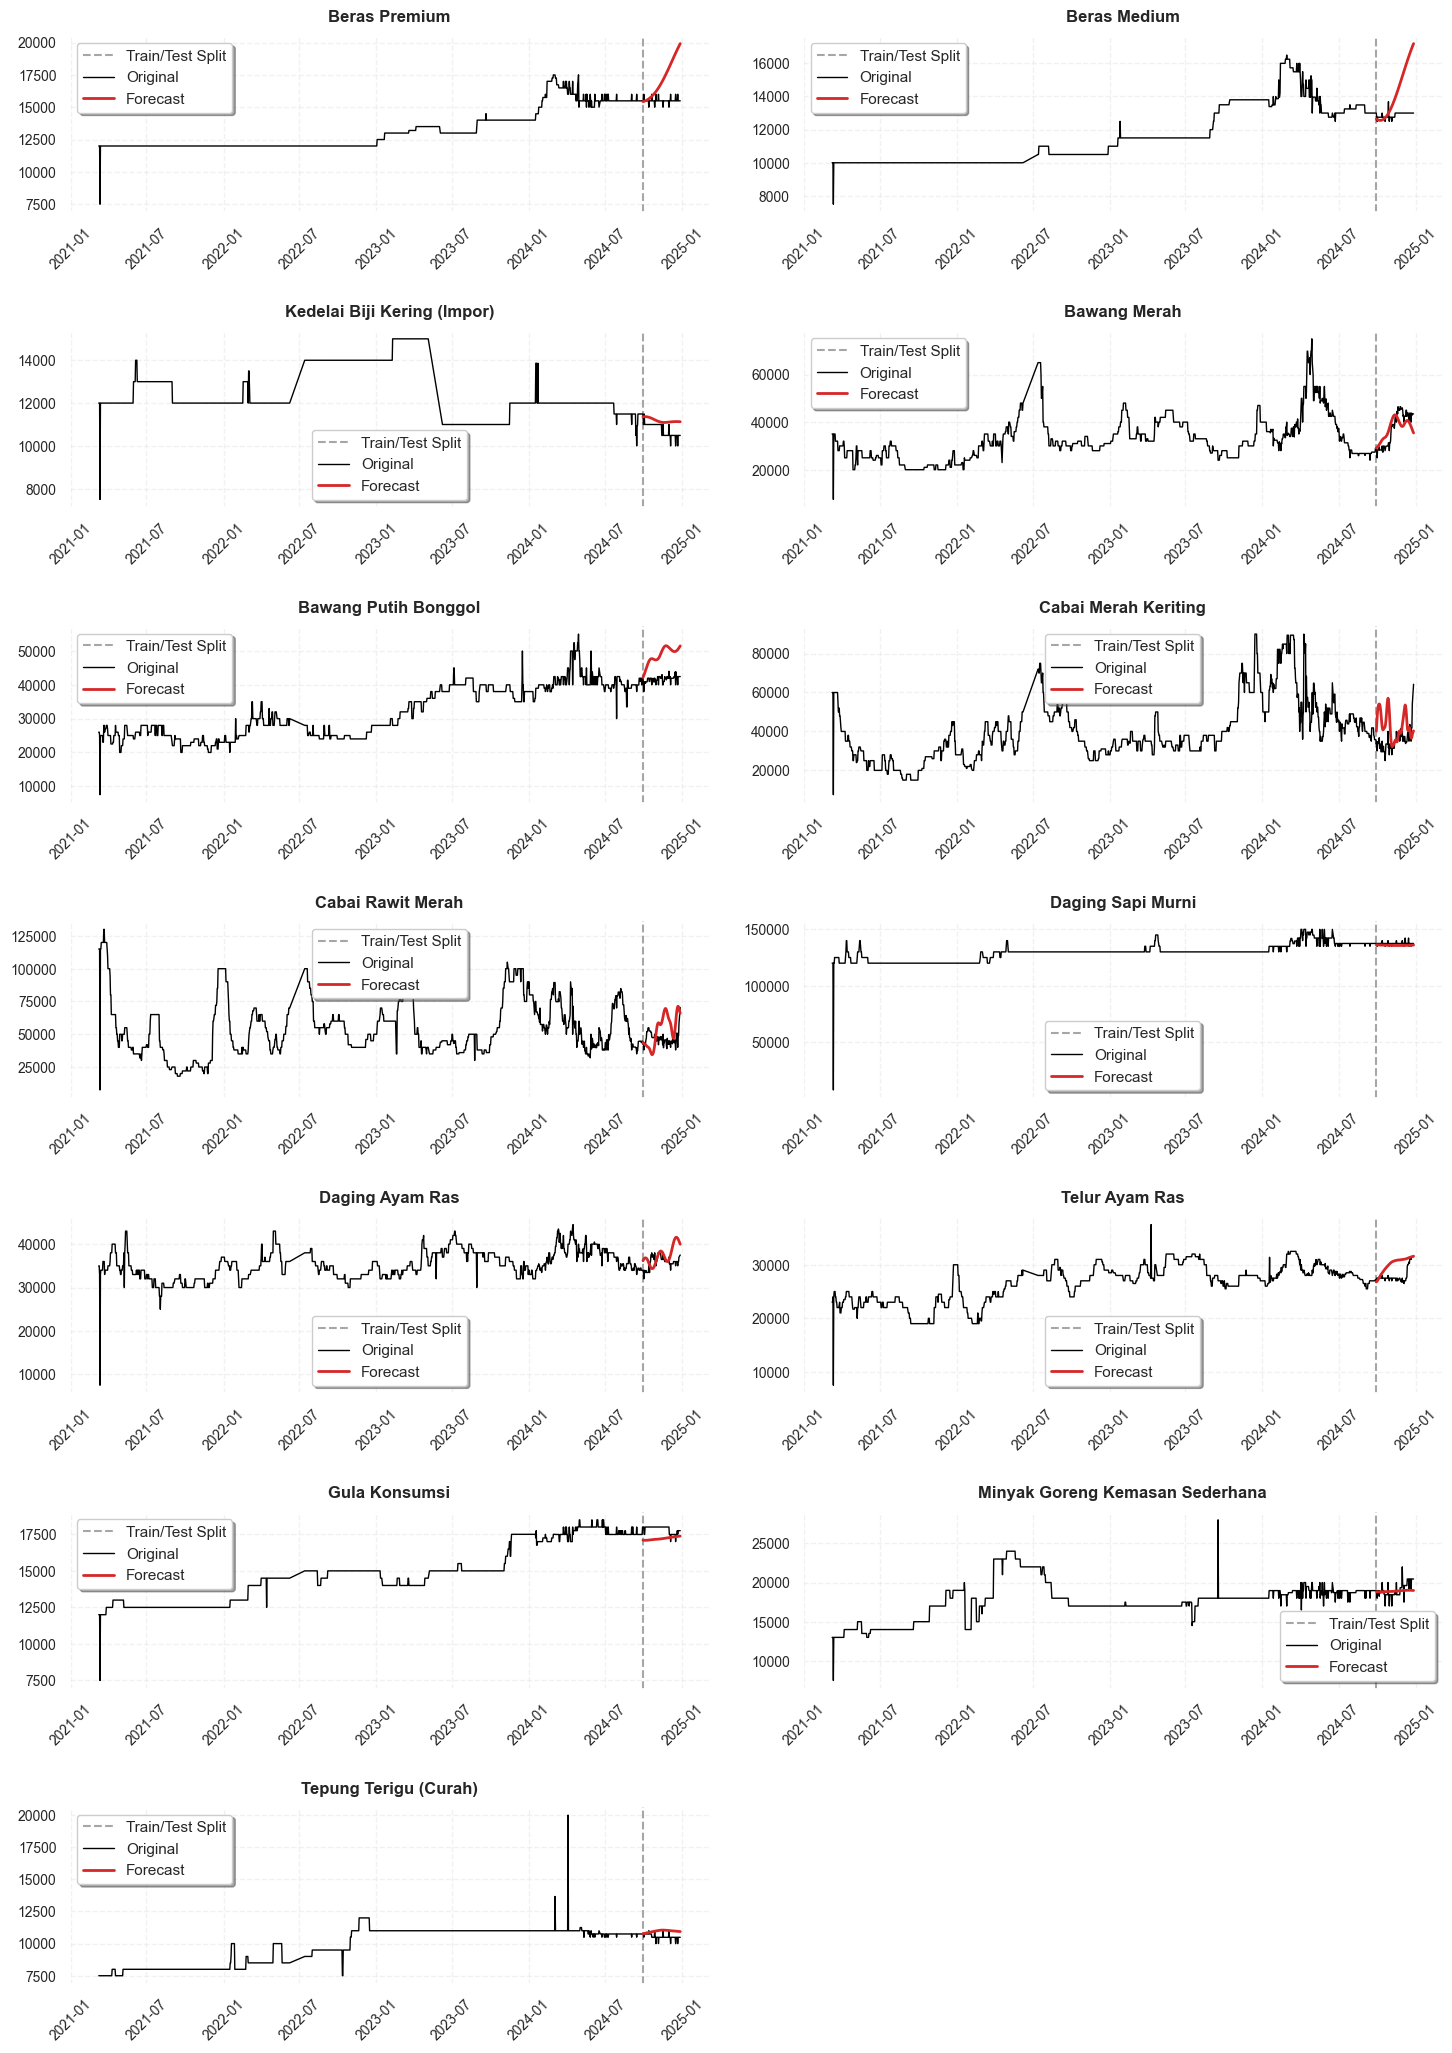

In [107]:
# ----------------- [Model Forecasting] ----------------- #
sns.set()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#E5E5E5'
plt.rcParams['grid.linestyle'] = '--'

n_cols = len(df.columns)
n_rows = (n_cols + 1) // 2

fig, ax = plt.subplots(n_rows, 2, figsize=(15, 3*n_rows))
result = {}

for i, col in enumerate(df.columns):
    print(f"# ----------------- [{col}] ----------------- #")
    
    ts = df[[col]].copy()
    ts = ts.interpolate(method='time')
    
    split_index = len(ts) - 90 
    train_data = ts.iloc[:split_index]
    test_data = ts.iloc[split_index:]

    model = SSA(train_data)
    model.embed(embedding_dimension=None, suspected_frequency=180, verbose=False)
    model.decompose(False)
    
    step_forecast = len(test_data)
    forecast = model.forecast_recurrent(steps_ahead=step_forecast, return_df=True)
    contribution = model.get_contributions(model.X_com, model.s, False)
    
    mapes = mape(test_data.values, forecast['Forecast'].values)
    smapes = smape(test_data.values, forecast['Forecast'].values)
    result[col] = {
        "MAPE (%)": round(mapes, 2),
        "SMAPE (%)": round(smapes, 2),
        "Banyak Nilai Singular": len(contribution[contribution['Contribution'] > 0]),
        'Stasioner?': results_df.loc[col]['Stationary']
    }
    print(f"MAPE: {mapes:.2f}")
    print(f"SMAPE: {smapes:.2f}")

    forecast = forecast.loc[forecast.index.isin(test_data.index)]
    split_index = ts.index[split_index]
    
    row_idx = i // 2
    col_idx = i % 2

    curr_ax = ax[row_idx, col_idx]
    
    curr_ax.axvline(x=split_index, color='gray', linestyle='--', alpha=0.7, label='Train/Test Split')
    
    curr_ax.plot(ts, label='Original', color='black', linewidth=1)  
    
    curr_ax.plot(forecast['Forecast'], label='Forecast', color='#D62728', linewidth=2)  
    
    curr_ax.set_title(f"{col}", pad=10, fontsize=12, fontweight='bold')
    curr_ax.grid(True, alpha=0.5)
    curr_ax.legend(frameon=True, fancybox=True, shadow=True, loc='best')
    
    curr_ax.spines['top'].set_visible(False)
    curr_ax.spines['right'].set_visible(False)
    curr_ax.spines['left'].set_visible(True)
    curr_ax.spines['bottom'].set_visible(True)
    curr_ax.tick_params(axis='both', which='major', labelsize=10)
    
    if isinstance(ts.index, pd.DatetimeIndex):
        curr_ax.tick_params(axis='x', rotation=45)
    
if n_cols & 1:
    if n_rows == 1:
        ax[-1].set_visible(False)
    else:
        ax[-1, -1].set_visible(False)

plt.tight_layout(pad=2.0)
plt.show()

,MAPE (%),SMAPE (%),Banyak Nilai Singular,Stasioner?
Komoditas,,,,
Beras Premium,15.75,17.35,6,False
Beras Medium,14.85,15.97,9,False
Kedelai Biji Kering (Impor),15.73,14.11,10,False
Bawang Merah,26.7,28.38,40,True
Bawang Putih Bonggol,24.34,29.28,15,False
Cabai Merah Keriting,36.02,31.31,66,True
Cabai Rawit Merah,37.77,32.11,54,True
Daging Sapi Murni,6.36,6.7,4,False
Daging Ayam Ras,7.86,7.99,19,True


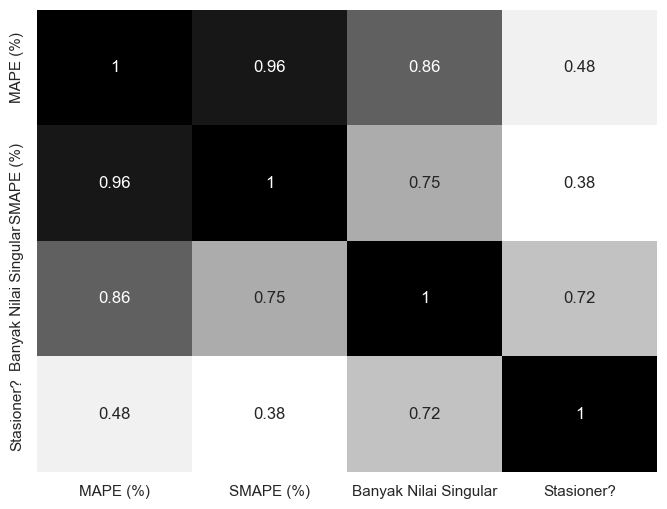

MAPE: 18.07 +- 10.15
SMAPE: 18.26 +- 8.99
Rata-rata Banyak Nilai Singular: 20.69


In [111]:
# ----------------- [Model Evaluation] ----------------- #
from matplotlib.colors import LinearSegmentedColormap
result_df = pd.DataFrame(result).T
result_df['Banyak Nilai Singular'] = result_df['Banyak Nilai Singular'].astype(int)
result_df['Stasioner?'] = result_df['Stasioner?'].replace({'Y': True, 'N': False})
result_df.index.name = "Komoditas"
display(result_df)

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_grayscale", ["white", "lightgray", "black"]
)

sns.set(style="white")
plt.figure(figsize=(8, 6))
corr = result_df.corr()
sns.heatmap(corr, annot=True, cmap=custom_cmap, cbar=False, linewidths=0)
plt.show()

print(f"MAPE: {result_df['MAPE (%)'].mean():.2f} +- {result_df['MAPE (%)'].std():.2f}")
print(f"SMAPE: {result_df['SMAPE (%)'].mean():.2f} +- {result_df['SMAPE (%)'].std():.2f}")
print(f"Rata-rata Banyak Nilai Singular: {result_df['Banyak Nilai Singular'].mean():.2f}")